In [39]:
# --- Core ---
import pandas as pd
import numpy as np
import re

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# --- Machine Learning ---
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.metrics import r2_score


# --- Gradient Boosting / Boosted Trees ---
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# --- Encoding ---
from category_encoders import TargetEncoder

# --- Hyperparameter Optimization ---
import optuna

# --- Explainability ---
import shap


In [2]:
data_base = pd.read_excel("regression_avito_deals.xlsx")

data = data_base.sample(frac=0.1, random_state=123)


In [3]:
data.shape

(75171, 16)

In [4]:
data.columns


Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'deal_probability'],
      dtype='object')

In [5]:
data.describe(include='all')

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,deal_probability
count,75171,75171,75171,75171,75171,75171,72053,42149,31816,75171,69455,7.084300e+04,75171.000000,75171,75171,75171.000000
unique,75171,66683,28,1129,9,47,328,219,554,53567,67727,NaN,NaN,15,3,NaN
top,1d32ffe80550,ee74bccca74f,Краснодарский край,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,Вторичка,Платье,В отличном состоянии,NaN,NaN,2017-03-28,Private,NaN
freq,1,52,7002,3169,34864,14103,11268,7529,2566,728,125,NaN,NaN,5799,54139,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.799178e+05,743.053571,NaN,NaN,0.139291
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.517287e+06,5558.906480,NaN,NaN,0.260660
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.000000,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+02,8.000000,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.300000e+03,28.000000,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000e+03,88.000000,NaN,NaN,0.151860


In [6]:
low_var_cols = []

for col in data.columns:
    top_freq = data[col].value_counts(normalize=True, dropna=False).max()

    if top_freq >= 0.98:
        low_var_cols.append(col)

print("Drop olunacaq sütunlar:", low_var_cols)

data = data.drop(columns=low_var_cols)


Drop olunacaq sütunlar: []


In [7]:
for col in data.columns:
    if data[col].nunique() == 1:
        print(f"{col}: {data[col].unique()}")
        data.drop(columns=[col], inplace=True)

In [8]:

missing_percent = (data.isnull().sum() / len(data)) * 100

missing_percent = missing_percent[missing_percent > 0]

for col, percent in missing_percent.items():
    print(f"{col}: {percent:.2f}%")


param_1: 4.15%
param_2: 43.93%
param_3: 57.68%
description: 7.60%
price: 5.76%


In [9]:
for col in data.columns:
    if col == 'param_3':
        data[col].fillna('Unknown', inplace=True)
    else:
        if data[col].dtype == object:
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_13456\1615579145.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13456\1615579145.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [10]:
data.select_dtypes('object').apply(pd.Series.nunique)

item_id                 75171
user_id                 66683
region                     28
city                     1129
parent_category_name        9
category_name              47
param_1                   328
param_2                   219
param_3                   555
title                   53567
description             67727
activation_date            15
user_type                   3
dtype: int64

In [11]:
group_map = {
    # Автомобили
    'Toyota': 'Автомобили',
    'Volkswagen': 'Автомобили',
    'Hyundai': 'Автомобили',
    'ВАЗ': 'Автомобили',
    'KIA': 'Автомобили',
    'Chevrolet': 'Автомобили',
    'Mercedes‑Benz': 'Автомобили',

    # Одежда и обувь
    'Верхняя одежда': 'Одежда и обувь',
    'Обувь': 'Одежда и обувь',
    'Платья и юбки': 'Одежда и обувь',
    'Брюки': 'Одежда и обувь',
    'Трикотаж': 'Одежда и обувь',
    'Шапки, варежки, шарфы': 'Одежда и обувь',

    # Техника и электроника
    'Стиральные машины': 'Техника и электроника',
    'Холодильники и морозильные камеры': 'Техника и электроника',
    'Видеокарты': 'Техника и электроника',
    'Процессоры': 'Техника и электроника',
    'Микроволновые печи': 'Техника и электроника',

    # Дом и ремонт
    'Дом': 'Дом и ремонт',
    'Поселений (ИЖС)': 'Дом и ремонт',
    'Строительство домов, коттеджей': 'Дом и ремонт',
    'Отделочные работы': 'Дом и ремонт',
    'Дача': 'Дом и ремонт',

    # Детские товары и игрушки
    'Товары для детей': 'Детские товары и игрушки',
    'Игрушки': 'Детские товары и игрушки',
    'Комбинезоны и боди': 'Детские товары и игрушки',

    # Услуги и бизнес
    'Аренда авто': 'Услуги и бизнес',
    'Маркетинг, реклама, PR': 'Услуги и бизнес',
    'Коммерческие перевозки': 'Услуги и бизнес',

    # Другие товары
    'Другое': 'Другие товары',
    # можно добавить остальные в группу “Другие товары”
}


data['param_2_grouped'] = data['param_2'].map(group_map).fillna('Другие товары')

In [12]:

categories_grouped = {
    "Одежда и мода": [
        "Женская одежда","Мужская одежда","Для девочек","Для мальчиков","Аксессуары",
        "Декоративные изделия","Ювелирные изделия","Парфюмерия"
    ],
    "Красота и личный уход": [
        "Средства для волос","Средства гигиены","Косметика","Для салонов красоты",
        "Для индивидуального ухода"
    ],
    "Дети и семья": [
        "Детские коляски","Игрушки","Детская мебель","Товары для кормления","Автомобильные кресла",
        "Товары для купания","Няни и сиделки","Игры с мячом","Игры для приставок"
    ],
    "Дом и мебель": [
        "Кровати, диваны и кресла","Шкафы и комоды","Столы и стулья","Для кухни",
        "Кухонные гарнитуры","Для дома","Предметы интерьера и искусство","Освещение",
        "Постельные принадлежности","Текстиль и ковры","Камины и обогреватели","Уборка"
    ],
    "Электроника и техника": [
        "iPhone","Samsung","Sony","Lenovo","Nokia","Asus","Xiaomi","Fly","Microsoft",
        "Meizu","ZTE","BlackBerry","Motorola","DEXP","Explay","Huawei",
        "Принтеры","Мониторы","Видео, DVD и Blu-ray плееры","Видеокамеры",
        "Фото и видеосъёмка","Зеркальные фотоаппараты","Компактные фотоаппараты",
        "Плёночные фотоаппараты","Объективы","Усилители и ресиверы",
        "Акустика, колонки, сабвуферы","Наушники","Клавиатуры и мыши",
        "Сетевое оборудование","МФУ, копиры и сканеры","Компьютерные столы и кресла"
    ],
    "Транспорт и спорт": [
        "Мотоциклы","Мопеды и скутеры","Грузовики","Трактора","Прицепы","Лёгкий транспорт",
        "Каяки и каноэ","Катера и яхты","Моторные лодки","Снегоходы",
        "Велосипеды и скейтбординг","Ролики и скейтбординг","Зимние виды спорта",
        "Фитнес и тренажёры","BMX","Спорт","Единоборства","Теннис, бадминтон, пинг-понг",
        "Бильярд и боулинг","Пейнтбол и страйкбол"
    ],
    "Животные и экзотика": [
        "С/х животные","Кролики","Грызуны","Сибирский хаски","Немецкая овчарка",
        "Йоркширский терьер","Мейн-кун","Бигль","Той-терьер","Курильский бобтейл",
        "Французский бульдог","Чихуахуа","Овчарка","Бенгальская","Турецкая ангора",
        "Канадский сфинкс","Аляскинский маламут","Шпиц","Шелти"
    ],
    "Другое / Разное": [
        "NaN","Продам","Сдам","Другое","Другая","Обучение, курсы","Для магазина",
        "Для ресторана","Торговля","Марки","Документы","Разное","Реклама, полиграфия"
    ]
}

group_map = {item: group for group, items in categories_grouped.items() for item in items}

data['param_1_grouped'] = data['param_1'].map(group_map).fillna('Другие товары')

data


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,deal_probability,param_2_grouped,param_1_grouped
20008,1d32ffe80550,f39abf77014f,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Другое,Unknown,Детские вещи пакетом,Отдам детские вещи пакетом 300 руб.размер от 6...,300.000000,10,2017-03-21,Private,0.00000,Другие товары,Одежда и мода
446970,c13b2c8a268e,1671b7e366e4,Саратовская область,Саратов,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,40,Сапоги,Зимние сапоги. Замш. На платформе... торг уместен,1500.000000,14,2017-03-25,Private,0.00000,Одежда и обувь,Одежда и мода
623076,627594210093,43aebc5caa96,Свердловская область,Екатеринбург,Хобби и отдых,Спорт и отдых,Другое,Обувь,Unknown,Брюки для бальных танцев,"Рост-90 см, обхват талии- 66 см",700.000000,5,2017-03-19,Private,0.00000,Одежда и обувь,Другое / Разное
283909,ea7601e8a8df,d30fdae30c67,Татарстан,Казань,Личные вещи,Часы и украшения,Бижутерия,Обувь,Unknown,Подставка для украшений,Продам бархатные подставки для украшений./\n9 ...,250.000000,20,2017-03-27,Private,0.00000,Одежда и обувь,Другие товары
340096,aa402705019b,c918b748b302,Кемеровская область,Новокузнецк,Для дома и дачи,Ремонт и строительство,Стройматериалы,Обувь,Unknown,Дом из бруса с верандой (6х6) м +2м,"Одноэтажный дом с жилым чердачным этажем, одно...",136300.000000,32,2017-03-22,Company,0.38925,Одежда и обувь,Другие товары
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101577,32505edaf3a0,e0f91531f503,Пермский край,Пермь,Хобби и отдых,Книги и журналы,Учебная литература,Обувь,Unknown,Химия книга,В отличном состоянии,100.000000,59,2017-03-21,Company,0.00000,Одежда и обувь,Другие товары
523166,c417bfffe4c5,6efaf97581c4,Ростовская область,Шахты,Личные вещи,Детская одежда и обувь,Для девочек,Комбинезоны и боди,86-92 см (1-2 года),Комбинезон зимний,Комбинезон зимний для девочки серый.,200.000000,31,2017-03-21,Private,0.00000,Детские товары и игрушки,Одежда и мода
579704,23391bf2fbb8,ec05047cd779,Омская область,Омск,Услуги,Предложение услуг,Другое,Обувь,Unknown,Ремонт автопластика,от 300 рублей ремонт зеркал,279917.795491,7,2017-03-17,Private,0.00000,Одежда и обувь,Другое / Разное
445916,2b5d7b2f9cc5,6657c0ffdc22,Челябинская область,Челябинск,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,Обувь,Unknown,Палантин,Размеры 176*110,300.000000,13,2017-03-19,Private,0.00000,Одежда и обувь,Одежда и мода


In [13]:
real_estate = [
    'Кирпичный', 'Новостройка', 'На длительный срок', 'За городом',
    'Металлический', 'Студия', 'В черте города', 'Подземный паркинг',
    'Вторичка'
]

locations = ['Азербайджан']

def group_param(x):
    x = str(x)
    
    if x.lower() == 'unknown':  
        return 'Other'
    if x in real_estate:
        return 'Real Estate'
    if x in locations:
        return 'Location'
    if re.search(r'\d', x) or 'см' in x or '<' in x or '>' in x or 'Без размера' in x:
        return 'Size'
    if re.search(r'^(21\d{2}|210\d)', x) or re.search(r'[A-Za-z]', x):
        return 'Car'
    return 'Other'


data['param_3_grouped'] = data['param_3'].apply(group_param)

In [14]:

data = data.reset_index(drop=True)

freq      = data['category_name'].value_counts()
threshold = 150   
rare      = freq[freq < threshold].index
data['category_grp'] = data['category_name'].apply(lambda x: 'Other' if x in rare else x)

global_mean = data['deal_probability'].mean()
m           = 200  

kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_vals = np.zeros(len(data))

for train_idx, val_idx in kf.split(data):
    train = data.iloc[train_idx]
    means  = train.groupby('category_grp')['deal_probability'].mean()
    counts = train.groupby('category_grp')['deal_probability'].count()
    smooth = (counts * means + m * global_mean) / (counts + m)
    smooth_dict = smooth.to_dict()
    
    encoded_vals[val_idx] = data.loc[val_idx, 'category_grp'].map(
        lambda x: smooth_dict.get(x, global_mean)
    )

data['category_encoded'] = encoded_vals


data['category_popularity']  = data.groupby('category_grp')['item_id'].transform('count')


In [15]:
top15 = data['city'].value_counts().nlargest(15).index
data['city_grouped'] = data['city'].where(data['city'].isin(top15), other='Other')
data['region_activity'] = data.groupby('region')['item_id'].transform('count')
data['desc_length'] = data['description'].astype(str).apply(len)

data['activation_date'] = pd.to_datetime(data['activation_date'])
data['act_year']    = data['activation_date'].dt.year
data['act_month']   = data['activation_date'].dt.month
data['act_weekday'] = data['activation_date'].dt.weekday  


In [16]:
cols_to_drop = ['category_name', 'user_id', 'item_id', 'activation_date', 'title', 'description', 'city', 'region', 'param_1', 'param_2', 'param_3']
data = data.drop(columns=cols_to_drop, axis=1)
data


,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,Личные вещи,300.000000,10,Private,0.00000,Другие товары,Одежда и мода,Other,Детская одежда и обувь,0.066446,13419,Нижний Новгород,3600,53,2017,3,1
1,Личные вещи,1500.000000,14,Private,0.00000,Одежда и обувь,Одежда и мода,Size,"Одежда, обувь, аксессуары",0.047672,14103,Саратов,2514,49,2017,3,5
2,Хобби и отдых,700.000000,5,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Спорт и отдых,0.147598,1201,Екатеринбург,4723,31,2017,3,6
3,Личные вещи,250.000000,20,Private,0.00000,Одежда и обувь,Другие товары,Other,Часы и украшения,0.084498,739,Казань,4125,50,2017,3,0
4,Для дома и дачи,136300.000000,32,Company,0.38925,Одежда и обувь,Другие товары,Other,Ремонт и строительство,0.141848,2942,Other,2225,944,2017,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,Хобби и отдых,100.000000,59,Company,0.00000,Одежда и обувь,Другие товары,Other,Книги и журналы,0.070733,643,Пермь,3165,20,2017,3,1
75167,Личные вещи,200.000000,31,Private,0.00000,Детские товары и игрушки,Одежда и мода,Size,Детская одежда и обувь,0.066326,13419,Other,4437,36,2017,3,1
75168,Услуги,279917.795491,7,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Предложение услуг,0.385074,3218,Омск,2155,27,2017,3,4
75169,Личные вещи,300.000000,13,Private,0.00000,Одежда и обувь,Одежда и мода,Other,"Одежда, обувь, аксессуары",0.046973,14103,Челябинск,3946,15,2017,3,6


In [17]:
data_lr = data.copy()
data_knn = data.copy()
data_rf_xgb_lgb_cb = data.copy()
data_cbc = data.copy()

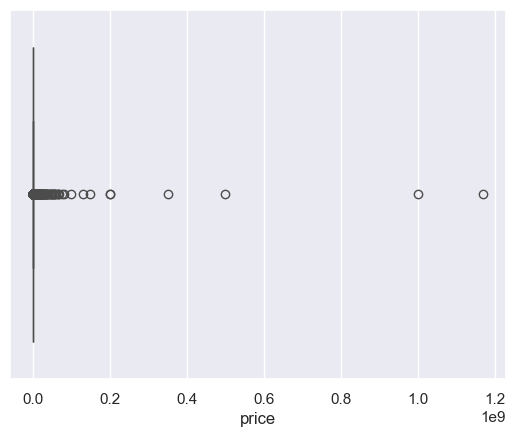

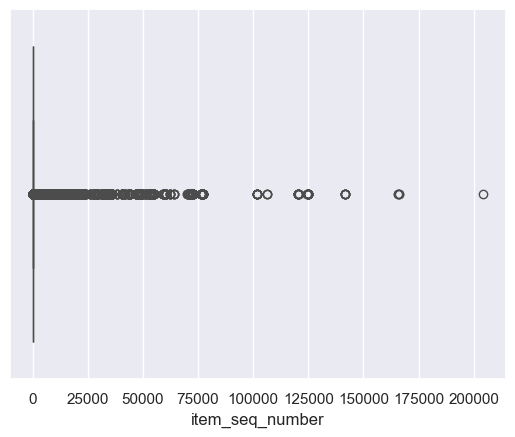

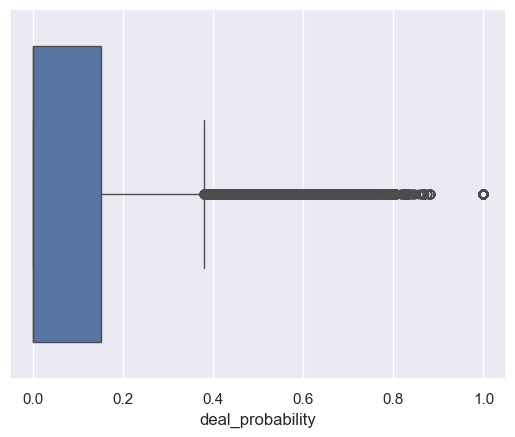

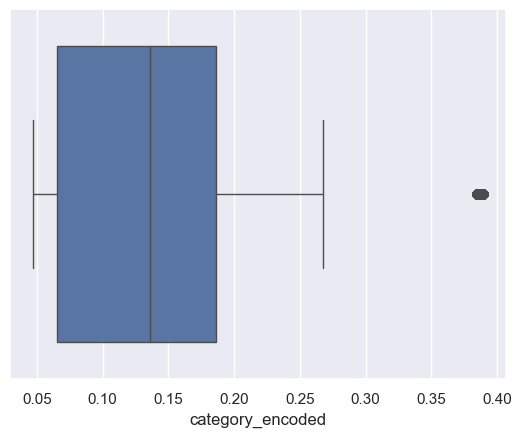

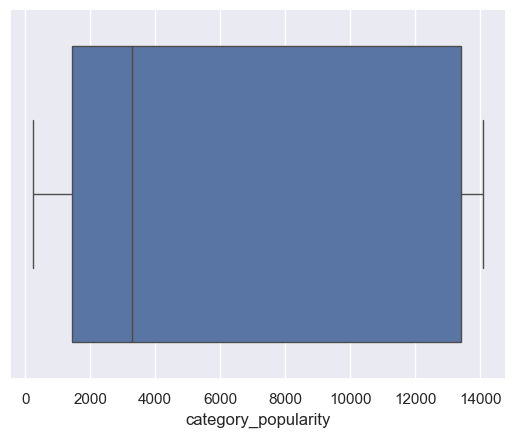

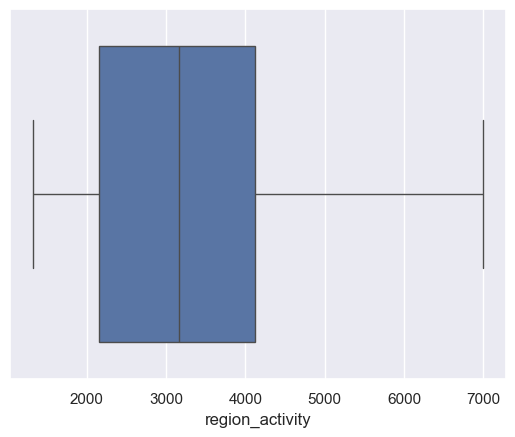

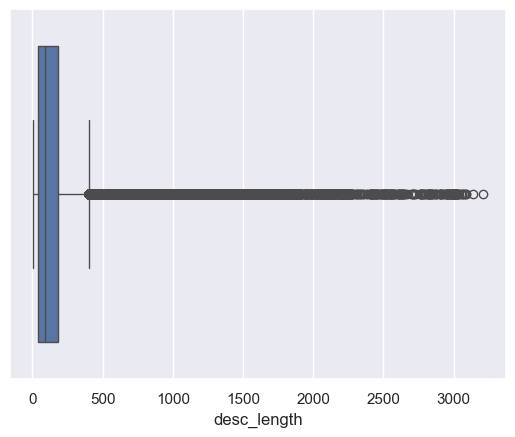

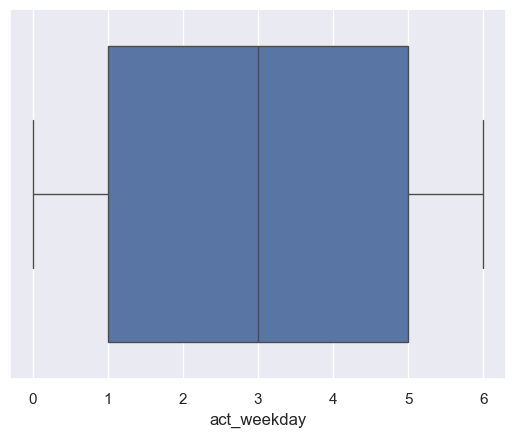

In [18]:
for i in data_knn.columns:
    if data_knn[i].dtypes!=object  and data_knn[i].nunique()>2:
        sns.boxplot(data=data_knn,x=data_knn[i])
        plt.show()

In [19]:
q1=data_knn.quantile(0.25, numeric_only=True)
q3=data_knn.quantile(0.75, numeric_only=True)
IQR=q3-q1

Lower = q1-1.5*IQR
Upper = q3+1.5*IQR

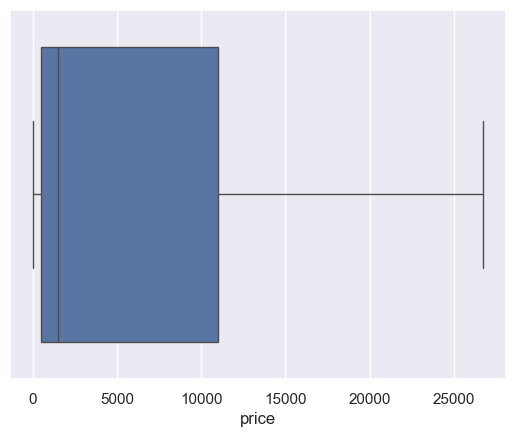

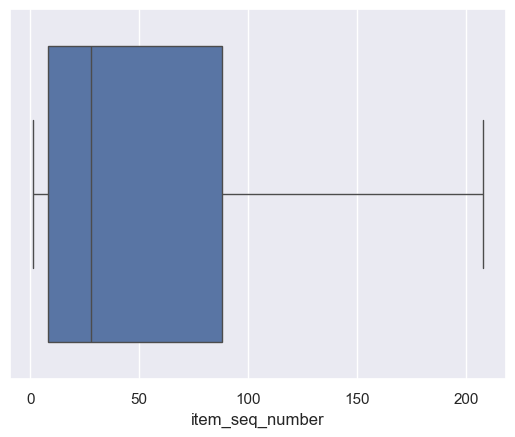

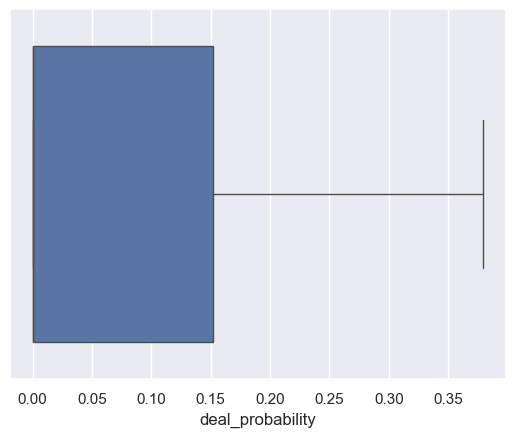

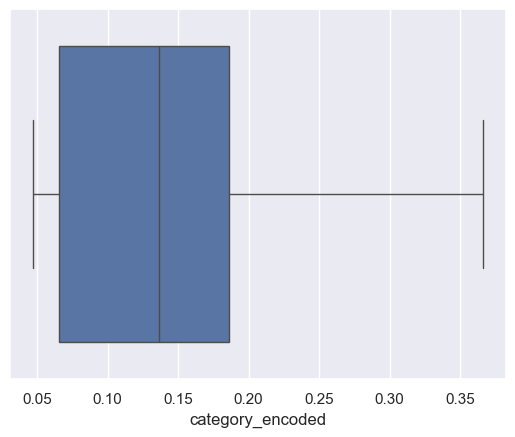

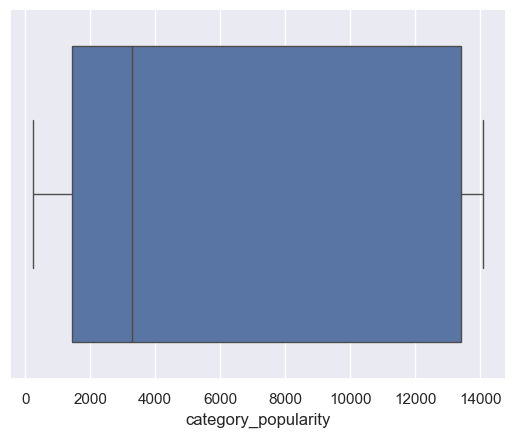

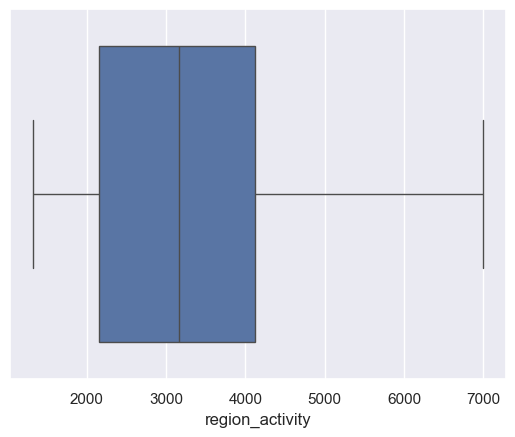

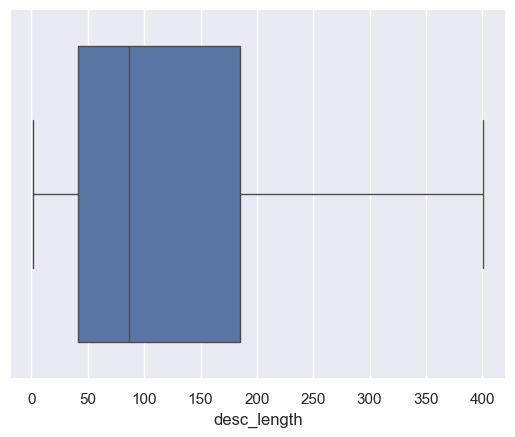

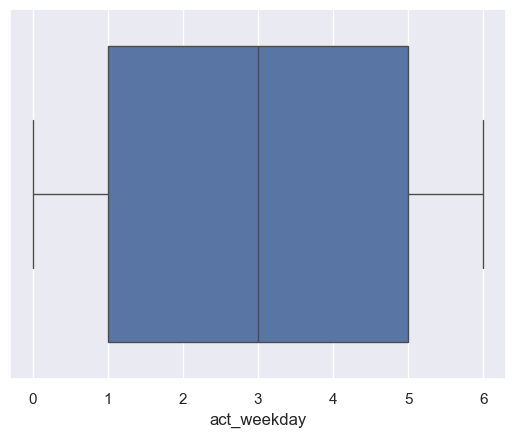

In [20]:
for i in data_knn.columns:
    if data_knn[i].dtypes!=object  and data[i].nunique()>2:
        data_knn[i] = np.where(data_knn[i] > Upper[i],Upper[i],data_knn[i])
        data_knn[i] = np.where(data_knn[i] < Lower[i],Lower[i],data_knn[i])
        sns.boxplot(data=data_knn,x=data_knn[i])
        plt.show()

In [21]:
data_knn = pd.get_dummies(data_knn, drop_first=True, dtype=int)
data_knn

,price,item_seq_number,deal_probability,category_encoded,category_popularity,region_activity,desc_length,act_year,act_month,act_weekday,...,city_grouped_Красноярск,city_grouped_Нижний Новгород,city_grouped_Новосибирск,city_grouped_Омск,city_grouped_Пермь,city_grouped_Ростов-на-Дону,city_grouped_Самара,city_grouped_Саратов,city_grouped_Уфа,city_grouped_Челябинск
0,300.0,10.0,0.00000,0.066446,13419.0,3600.0,53.0,2017,3,1.0,...,0,1,0,0,0,0,0,0,0,0
1,1500.0,14.0,0.00000,0.047672,14103.0,2514.0,49.0,2017,3,5.0,...,0,0,0,0,0,0,0,1,0,0
2,700.0,5.0,0.00000,0.147598,1201.0,4723.0,31.0,2017,3,6.0,...,0,0,0,0,0,0,0,0,0,0
3,250.0,20.0,0.00000,0.084498,739.0,4125.0,50.0,2017,3,0.0,...,0,0,0,0,0,0,0,0,0,0
4,26750.0,32.0,0.37965,0.141848,2942.0,2225.0,401.0,2017,3,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,100.0,59.0,0.00000,0.070733,643.0,3165.0,20.0,2017,3,1.0,...,0,0,0,0,1,0,0,0,0,0
75167,200.0,31.0,0.00000,0.066326,13419.0,4437.0,36.0,2017,3,1.0,...,0,0,0,0,0,0,0,0,0,0
75168,26750.0,7.0,0.00000,0.366589,3218.0,2155.0,27.0,2017,3,4.0,...,0,0,0,1,0,0,0,0,0,0
75169,300.0,13.0,0.00000,0.046973,14103.0,3946.0,15.0,2017,3,6.0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
def target_correlation(data, target, threshold=0.1):
    
    corr_matrix = data.corr(method='spearman', numeric_only=True)
    
    target_correlations = corr_matrix[target].abs() > threshold
    
    variables_explaining_target = target_correlations[target_correlations].index.tolist()

    variables_explaining_target.remove(target)
    
    result_explaining_target = pd.DataFrame(
    {'Variable': variables_explaining_target,
    'Correlation with Target': corr_matrix.loc[variables_explaining_target, target]})
    
    result_explaining_target.reset_index(drop=True, inplace=True)
    
    return result_explaining_target

target_result = target_correlation(data_knn, 'deal_probability')
target_result

,Variable,Correlation with Target
0,price,0.229872
1,item_seq_number,-0.177473
2,category_encoded,0.370149
3,category_popularity,-0.254497
4,desc_length,0.104595
5,parent_category_name_Животные,0.100891
6,parent_category_name_Личные вещи,-0.328607
7,parent_category_name_Недвижимость,0.166739
8,parent_category_name_Транспорт,0.151050
9,parent_category_name_Услуги,0.213281


In [23]:
def intercorrelation(data, target, threshold=0.7):
    
    corr_matrix = data.corr(method='spearman', numeric_only=True)
    
    highly_correlated_variables = (np.abs(corr_matrix) > threshold) & (corr_matrix != 1.0)
    
    independent_variable_pairs = np.where(highly_correlated_variables)
    
    correlated_pairs_set = set()
   
    for var1, var2 in zip(independent_variable_pairs[0], independent_variable_pairs[1]):

        if var1 < var2:
            correlated_pairs_set.add((corr_matrix.index[var1], corr_matrix.columns[var2]))
        else:
            correlated_pairs_set.add((corr_matrix.index[var2], corr_matrix.columns[var1]))
    
    result_intercorrelated_independent = pd.DataFrame(list(correlated_pairs_set), columns=['Variable 1', 'Variable 2'])
    
    return result_intercorrelated_independent

intercorrelated_result = intercorrelation(data_knn, 'deal_probability')
intercorrelated_result

,Variable 1,Variable 2
0,param_3_grouped_Real Estate,category_grp_Квартиры
1,category_popularity,parent_category_name_Личные вещи
2,param_3_grouped_Other,param_3_grouped_Size
3,parent_category_name_Недвижимость,category_grp_Квартиры
4,category_encoded,param_1_grouped_Одежда и мода
5,parent_category_name_Личные вещи,param_1_grouped_Одежда и мода
6,parent_category_name_Для бизнеса,category_grp_Оборудование для бизнеса
7,param_2_grouped_Дом и ремонт,"category_grp_Дома, дачи, коттеджи"
8,param_2_grouped_Другие товары,param_2_grouped_Одежда и обувь
9,param_1_grouped_Одежда и мода,param_3_grouped_Size


In [24]:
target_result.Variable.tolist()

['price',
 'item_seq_number',
 'category_encoded',
 'category_popularity',
 'desc_length',
 'parent_category_name_Животные',
 'parent_category_name_Личные вещи',
 'parent_category_name_Недвижимость',
 'parent_category_name_Транспорт',
 'parent_category_name_Услуги',
 'param_2_grouped_Дом и ремонт',
 'param_2_grouped_Другие товары',
 'param_2_grouped_Одежда и обувь',
 'param_1_grouped_Другие товары',
 'param_1_grouped_Другое / Разное',
 'param_1_grouped_Одежда и мода',
 'param_3_grouped_Other',
 'param_3_grouped_Size',
 'category_grp_Автомобили',
 'category_grp_Детская одежда и обувь',
 'category_grp_Квартиры',
 'category_grp_Одежда, обувь, аксессуары',
 'category_grp_Предложение услуг']

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data_knn, variables):
    vif_data = data_knn[variables]
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    vif_result = pd.DataFrame({'VIF': vif_values, 'Features': variables})
    return vif_result

vif_result = calculate_vif(data_knn, [
 'price',
 'item_seq_number',
 'category_encoded',
 #'category_popularity',
 'desc_length',
 'parent_category_name_Животные',
 'parent_category_name_Личные вещи',
 'parent_category_name_Недвижимость',
 'parent_category_name_Транспорт',
# 'parent_category_name_Услуги',
 'param_2_grouped_Дом и ремонт',
 'param_2_grouped_Другие товары',
 #'param_2_grouped_Одежда и обувь',
 'param_1_grouped_Другие товары',
 'param_1_grouped_Другое / Разное',
 #'param_1_grouped_Одежда и мода',
 #'param_3_grouped_Other',
 'param_3_grouped_Size',
 'category_grp_Автомобили',
 'category_grp_Детская одежда и обувь',
 'category_grp_Квартиры',
 'category_grp_Одежда, обувь, аксессуары',
 #'category_grp_Предложение услуг'
])

vif_result

,VIF,Features
0,3.674861,price
1,1.825175,item_seq_number
2,4.295565,category_encoded
3,2.664019,desc_length
4,1.151645,parent_category_name_Животные
5,5.973411,parent_category_name_Личные вещи
6,6.884925,parent_category_name_Недвижимость
7,5.030032,parent_category_name_Транспорт
8,1.854341,param_2_grouped_Дом и ремонт
9,2.328869,param_2_grouped_Другие товары


In [26]:
cols_to_drop = [
    'param_1_grouped_Одежда и мода',
    'param_3_grouped_Other', 
    'category_grp_Предложение услуг',
    'parent_category_name_Услуги',
    'param_2_grouped_Одежда и обувь'
]

data_knn.drop(columns=cols_to_drop, inplace=True)
data

,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,Личные вещи,300.000000,10,Private,0.00000,Другие товары,Одежда и мода,Other,Детская одежда и обувь,0.066446,13419,Нижний Новгород,3600,53,2017,3,1
1,Личные вещи,1500.000000,14,Private,0.00000,Одежда и обувь,Одежда и мода,Size,"Одежда, обувь, аксессуары",0.047672,14103,Саратов,2514,49,2017,3,5
2,Хобби и отдых,700.000000,5,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Спорт и отдых,0.147598,1201,Екатеринбург,4723,31,2017,3,6
3,Личные вещи,250.000000,20,Private,0.00000,Одежда и обувь,Другие товары,Other,Часы и украшения,0.084498,739,Казань,4125,50,2017,3,0
4,Для дома и дачи,136300.000000,32,Company,0.38925,Одежда и обувь,Другие товары,Other,Ремонт и строительство,0.141848,2942,Other,2225,944,2017,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,Хобби и отдых,100.000000,59,Company,0.00000,Одежда и обувь,Другие товары,Other,Книги и журналы,0.070733,643,Пермь,3165,20,2017,3,1
75167,Личные вещи,200.000000,31,Private,0.00000,Детские товары и игрушки,Одежда и мода,Size,Детская одежда и обувь,0.066326,13419,Other,4437,36,2017,3,1
75168,Услуги,279917.795491,7,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Предложение услуг,0.385074,3218,Омск,2155,27,2017,3,4
75169,Личные вещи,300.000000,13,Private,0.00000,Одежда и обувь,Одежда и мода,Other,"Одежда, обувь, аксессуары",0.046973,14103,Челябинск,3946,15,2017,3,6


In [27]:
#RF and XGB and CT and lGB

In [28]:
le = LabelEncoder()

for i in data_rf_xgb_lgb_cb.columns:
    data_rf_xgb_lgb_cb[i] = le.fit_transform(data_rf_xgb_lgb_cb[i])
data_rf_xgb_lgb_cb

,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,4,172,9,1,0,3,6,2,8,10,42,7,21,52,0,0,1
1,4,433,13,1,0,4,6,4,26,3,43,13,16,48,0,0,5
2,8,291,4,1,0,4,3,2,37,99,28,3,26,30,0,0,6
3,4,150,19,1,0,4,2,2,43,22,25,4,24,49,0,0,0
4,2,1749,31,0,3759,4,2,2,35,90,35,0,14,943,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,8,70,58,0,0,4,2,2,14,16,24,10,19,19,0,0,1
75167,4,119,30,1,0,1,6,4,8,9,42,0,25,35,0,0,1
75168,7,1884,6,1,0,4,3,2,31,216,37,9,11,26,0,0,4
75169,4,172,12,1,0,4,6,2,26,2,43,15,23,14,0,0,6


In [29]:
data_cbc

,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,Личные вещи,300.000000,10,Private,0.00000,Другие товары,Одежда и мода,Other,Детская одежда и обувь,0.066446,13419,Нижний Новгород,3600,53,2017,3,1
1,Личные вещи,1500.000000,14,Private,0.00000,Одежда и обувь,Одежда и мода,Size,"Одежда, обувь, аксессуары",0.047672,14103,Саратов,2514,49,2017,3,5
2,Хобби и отдых,700.000000,5,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Спорт и отдых,0.147598,1201,Екатеринбург,4723,31,2017,3,6
3,Личные вещи,250.000000,20,Private,0.00000,Одежда и обувь,Другие товары,Other,Часы и украшения,0.084498,739,Казань,4125,50,2017,3,0
4,Для дома и дачи,136300.000000,32,Company,0.38925,Одежда и обувь,Другие товары,Other,Ремонт и строительство,0.141848,2942,Other,2225,944,2017,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,Хобби и отдых,100.000000,59,Company,0.00000,Одежда и обувь,Другие товары,Other,Книги и журналы,0.070733,643,Пермь,3165,20,2017,3,1
75167,Личные вещи,200.000000,31,Private,0.00000,Детские товары и игрушки,Одежда и мода,Size,Детская одежда и обувь,0.066326,13419,Other,4437,36,2017,3,1
75168,Услуги,279917.795491,7,Private,0.00000,Одежда и обувь,Другое / Разное,Other,Предложение услуг,0.385074,3218,Омск,2155,27,2017,3,4
75169,Личные вещи,300.000000,13,Private,0.00000,Одежда и обувь,Одежда и мода,Other,"Одежда, обувь, аксессуары",0.046973,14103,Челябинск,3946,15,2017,3,6


In [40]:
output = data['deal_probability']

In [41]:
inputs_knn = data_knn.drop('deal_probability', axis=1)
inputs_rf_xgb_lgb_cb = data_rf_xgb_lgb_cb.drop('deal_probability', axis=1)
inputs_cbc = data_cbc.drop('deal_probability', axis=1)

In [42]:
scaler = StandardScaler()
scaler.fit(inputs_knn)
inputs_scaled = scaler.transform(inputs_knn)

data_scaled_knn = pd.DataFrame(inputs_scaled, columns=inputs_knn.columns)

data_scaled_knn

,price,item_seq_number,category_encoded,category_popularity,region_activity,desc_length,act_year,act_month,act_weekday,parent_category_name_Для бизнеса,...,city_grouped_Красноярск,city_grouped_Нижний Новгород,city_grouped_Новосибирск,city_grouped_Омск,city_grouped_Пермь,city_grouped_Ростов-на-Дону,city_grouped_Самара,city_grouped_Саратов,city_grouped_Уфа,city_grouped_Челябинск
0,-0.697613,-0.721669,-0.847883,1.220271,0.186597,-0.656731,0.0,0.0,-0.962688,-0.109833,...,-0.158844,5.301151,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
1,-0.582203,-0.665182,-1.078211,1.341843,-0.511756,-0.689276,0.0,0.0,1.009855,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,6.744475,-0.166892,-0.183782
2,-0.659143,-0.792278,0.147719,-0.951316,0.908743,-0.835727,0.0,0.0,1.502991,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
3,-0.702422,-0.580452,-0.626406,-1.033430,0.524199,-0.681140,0.0,0.0,-1.455823,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
4,1.846220,-0.410990,0.077181,-0.641876,-0.697598,2.174649,0.0,0.0,-0.469552,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,-0.716848,-0.029702,-0.795284,-1.050493,-0.093130,-0.925224,0.0,0.0,-0.962688,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,5.570327,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
75167,-0.707231,-0.425112,-0.849351,1.220271,0.724831,-0.795046,0.0,0.0,-0.962688,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
75168,1.846220,-0.764035,2.834386,-0.592821,-0.742612,-0.868271,0.0,0.0,0.516720,-0.109833,...,-0.158844,-0.188638,-0.197752,5.933763,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,-0.183782
75169,-0.697613,-0.679304,-1.086782,1.341843,0.409093,-0.965905,0.0,0.0,1.502991,-0.109833,...,-0.158844,-0.188638,-0.197752,-0.168527,-0.179523,-0.187197,-0.169277,-0.148270,-0.166892,5.441239


In [43]:

X_train_knn, X_test_knn, y_train, y_test = train_test_split(data_scaled_knn, output, test_size=0.2, random_state=42)
X_train_rf_xgb_lgb_cb, X_test_rf_xgb_lgb_cb, y_train, y_test = train_test_split(inputs_rf_xgb_lgb_cb, output, test_size=0.2, random_state=42)
X_train_cbc, X_test_cbc, y_train, y_test = train_test_split(inputs_cbc, output, test_size=0.2, random_state=42)

In [44]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    try:
        
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        mae_train  = metrics.mean_absolute_error(y_train, y_pred_train)
        mse_train  = metrics.mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        r2_train   = metrics.r2_score(y_train, y_pred_train)

        print(f"\n===== {model_name} | TRAIN RESULTS =====")
        print(f"R² Score : {r2_train:.4f} ({r2_train * 100:.2f}%)")
        print(f"MAE      : {mae_train:.4f}")
        print(f"MSE      : {mse_train:.4f}")
        print(f"RMSE     : {rmse_train:.4f}")

        y_pred_test = model.predict(X_test)
        mae_test  = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test  = metrics.mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        r2_test   = metrics.r2_score(y_test, y_pred_test)

        print(f"\n===== {model_name} | TEST RESULTS =====")
        print(f"R² Score : {r2_test:.4f} ({r2_test * 100:.2f}%)")
        print(f"MAE      : {mae_test:.4f}")
        print(f"MSE      : {mse_test:.4f}")
        print(f"RMSE     : {rmse_test:.4f}")

        return [r2_train, r2_test]

    except Exception as e:
        print(f"⚠️ Error while evaluating regression model '{model_name}': {e}")
        return None


In [45]:
for i in data_cbc.columns:
    if data_cbc[i].dtypes==object:
        print(i)

parent_category_name
user_type
param_2_grouped
param_1_grouped
param_3_grouped
category_grp
city_grouped


In [46]:
models = []

knn_reg = KNeighborsRegressor()
rf_reg  = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
lgb_reg = LGBMRegressor(random_state=42)
cat_reg = CatBoostRegressor(random_state=42)
cat_reg_cus = CatBoostRegressor(cat_features=[
'parent_category_name',
'user_type',
'param_2_grouped',
'param_1_grouped',
'param_3_grouped',
'category_grp',
'city_grouped'
],random_state=42)

models.extend([
    ('KNN_Reg', knn_reg),
    ('RF_Reg', rf_reg),
    ('XGBoost_Reg', xgb_reg),
    ('LGBM_Reg', lgb_reg),
    ('CatBoost_Reg', cat_reg),
    ('CatBoost_Reg_Custom', cat_reg_cus)
])


In [47]:
r2_df = pd.DataFrame(columns=['Model', 'Train R2', 'Test R2'])

for model_name, model in models:
    if model_name == 'KNN':
        r2_pred = train_and_evaluate_model(model_name, model, X_train_knn, y_train, X_test_knn, y_test)
    elif model_name == 'CatBoost_Custom':
        r2_pred = train_and_evaluate_model(model_name, model, X_train_cbc, y_train, X_test_cbc, y_test)
    else:
        r2_pred = train_and_evaluate_model(model_name, model, X_train_rf_xgb_lgb_cb, y_train, X_test_rf_xgb_lgb_cb, y_test)

    if r2_pred is not None:
        r2_df = pd.concat([
            r2_df,
            pd.DataFrame({
                'Model': [model_name],
                'Train R2': [r2_pred[0]],
                'Test R2': [r2_pred[1]]
            })
        ], ignore_index=True)

r2_df_sorted = r2_df.sort_values(by='Test R2', ascending=False)

r2_df_sorted



===== KNN_Reg | TRAIN RESULTS =====
R² Score : 0.3285 (32.85%)
MAE      : 0.1378
MSE      : 0.0454
RMSE     : 0.2131

===== KNN_Reg | TEST RESULTS =====
R² Score : -0.0151 (-1.51%)
MAE      : 0.1747
MSE      : 0.0703
RMSE     : 0.2651


C:\Users\user\AppData\Local\Temp\ipykernel_13456\211654123.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_df = pd.concat([



===== RF_Reg | TRAIN RESULTS =====
R² Score : 0.8785 (87.85%)
MAE      : 0.0627
MSE      : 0.0082
RMSE     : 0.0906

===== RF_Reg | TEST RESULTS =====
R² Score : 0.1376 (13.76%)
MAE      : 0.1733
MSE      : 0.0597
RMSE     : 0.2444

===== XGBoost_Reg | TRAIN RESULTS =====
R² Score : 0.3489 (34.89%)
MAE      : 0.1410
MSE      : 0.0440
RMSE     : 0.2098

===== XGBoost_Reg | TEST RESULTS =====
R² Score : 0.1638 (16.38%)
MAE      : 0.1626
MSE      : 0.0579
RMSE     : 0.2406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 60136, number of used features: 14
[LightGBM] [Info] Start training from score 0.138698

===== LGBM_Reg | TRAIN RESULTS =====
R² Score : 0.2367 (23.67%)
MAE      : 0.1551
MSE      : 0.0516
RMSE     : 0.2272

,Model,Train R2,Test R2
5,CatBoost_Reg_Custom,0.231729,0.180391
4,CatBoost_Reg,0.292085,0.176060
3,LGBM_Reg,0.236659,0.173711
2,XGBoost_Reg,0.348908,0.163770
1,RF_Reg,0.878515,0.137639
0,KNN_Reg,0.328492,-0.015101


In [48]:
r2_df_sorted

,Model,Train R2,Test R2
5,CatBoost_Reg_Custom,0.231729,0.180391
4,CatBoost_Reg,0.292085,0.176060
3,LGBM_Reg,0.236659,0.173711
2,XGBoost_Reg,0.348908,0.163770
1,RF_Reg,0.878515,0.137639
0,KNN_Reg,0.328492,-0.015101


In [49]:
# KNN

from sklearn.model_selection import cross_val_score
import optuna

def best_params_for_model(trial):
    param = {
    'n_neighbors': trial.suggest_int('n_neighbors', 1, 50), 
    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  
    'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  
    'leaf_size': trial.suggest_int('leaf_size', 10, 100),  
    'p': trial.suggest_int('p', 1, 2),  
    'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']) 
}

    knn_clf = KNeighborsRegressor(**param)

    accuracy = cross_val_score(knn_clf, X_train_knn, y_train, cv=5, scoring='r2', n_jobs=-1).mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_knn_model = KNeighborsRegressor(**best_params)

[I 2025-11-10 15:54:49,495] A new study created in memory with name: no-name-ab6b7b38-b2f5-451b-b85f-a651e4661e34
[I 2025-11-10 15:57:19,856] Trial 0 finished with value: 0.13857337684006055 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 93, 'p': 2, 'metric': 'manhattan'}. Best is trial 0 with value: 0.13857337684006055.
[I 2025-11-10 15:57:33,694] Trial 1 finished with value: 0.13990541351655614 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 14, 'p': 2, 'metric': 'minkowski'}. Best is trial 1 with value: 0.13990541351655614.
[I 2025-11-10 15:58:24,954] Trial 2 finished with value: 0.09029819751007181 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 92, 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 0.13990541351655614.
[I 2025-11-10 16:00:55,352] Trial 3 finished with value: 0.13758859681567442 and parameters: {'n_neighbors': 28, 'we

Best trial:
  Value: 0.144
  Params:  {'n_neighbors': 47, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 62, 'p': 1, 'metric': 'euclidean'}


In [51]:
def best_params_for_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20)
    }

    rf_reg = RandomForestRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    r2 = cross_val_score(rf_reg, X_train_rf_xgb_lgb_cb, y_train, cv=kf, scoring='r2', n_jobs=-1).mean()
    return r2

# Optuna axtarışı
study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_rf, n_trials=30)

best_params = study.best_params
print('Best trial value (R²): {:.4f}'.format(study.best_value))
print('Best params:', best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=42)


[I 2025-11-10 16:14:29,475] A new study created in memory with name: no-name-e2526b61-a6e1-4884-bd0e-256ec167ef0f
[I 2025-11-10 16:14:55,678] Trial 0 finished with value: 0.1764332169312278 and parameters: {'n_estimators': 465, 'max_features': 'log2', 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.1764332169312278.
[I 2025-11-10 16:15:10,317] Trial 1 finished with value: 0.17561763827113847 and parameters: {'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 14, 'min_samples_split': 29, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.1764332169312278.
[I 2025-11-10 16:15:24,416] Trial 2 finished with value: 0.17523326898524832 and parameters: {'n_estimators': 261, 'max_features': 'sqrt', 'max_depth': 12, 'min_samples_split': 25, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.1764332169312278.
[I 2025-11-10 16:15:34,467] Trial 3 finished with value: 0.1650995325590281 and parameters: {'n_estimators': 313, 'max_feature

Best trial value (R²): 0.1771
Best params: {'n_estimators': 430, 'max_features': 'log2', 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 9}


In [52]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    xgb_reg = XGBRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    r2 = cross_val_score(xgb_reg, X_train_rf_xgb_lgb_cb, y_train, cv=kf, scoring='r2', n_jobs=-1).mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

best_params = study.best_params
print('Best trial value (R²): {:.4f}'.format(study.best_value))
print('Best params:', best_params)

best_xgb_model = XGBRegressor(**best_params, random_state=42)


[I 2025-11-10 16:22:58,889] A new study created in memory with name: no-name-ccd7f28b-8f26-4332-ad23-f47fc3a92a04
[I 2025-11-10 16:23:01,832] Trial 0 finished with value: 0.15674032280202707 and parameters: {'n_estimators': 599, 'learning_rate': 0.011859706729942226, 'max_depth': 3, 'subsample': 0.866270938354085, 'colsample_bytree': 0.8073430736435034, 'gamma': 0.7562242472283858, 'reg_alpha': 0.43790134945597103, 'reg_lambda': 0.4608427274770691}. Best is trial 0 with value: 0.15674032280202707.
[I 2025-11-10 16:23:05,132] Trial 1 finished with value: 0.16135607175675376 and parameters: {'n_estimators': 723, 'learning_rate': 0.012720319830245663, 'max_depth': 3, 'subsample': 0.7369276434680545, 'colsample_bytree': 0.8883921261636039, 'gamma': 0.5165640550581583, 'reg_alpha': 0.27125041630374636, 'reg_lambda': 0.6627582763830321}. Best is trial 1 with value: 0.16135607175675376.
[I 2025-11-10 16:23:08,403] Trial 2 finished with value: 0.15103577800499096 and parameters: {'n_estimators

Best trial value (R²): 0.1780
Best params: {'n_estimators': 900, 'learning_rate': 0.025637989327555958, 'max_depth': 5, 'subsample': 0.88494101753325, 'colsample_bytree': 0.7453419140793507, 'gamma': 0.005790983146448547, 'reg_alpha': 0.9825283999398686, 'reg_lambda': 0.039912692371816993}


In [53]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    lgb_reg = LGBMRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    r2 = cross_val_score(lgb_reg, X_train_rf_xgb_lgb_cb, y_train, cv=kf, scoring='r2', n_jobs=-1).mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=20)

best_params = study.best_params
print('Best trial value (R²): {:.4f}'.format(study.best_value))
print('Best params:', best_params)

best_lgb_model = LGBMRegressor(**best_params, random_state=42)


[I 2025-11-10 16:25:41,883] A new study created in memory with name: no-name-ec58e897-053f-45f8-9c11-831ecdf5792e
[I 2025-11-10 16:25:55,021] Trial 0 finished with value: 0.1736345650519137 and parameters: {'n_estimators': 880, 'learning_rate': 0.03597154116792743, 'max_depth': 6, 'num_leaves': 32, 'subsample': 0.7268381442563543, 'colsample_bytree': 0.7717648801560504, 'reg_alpha': 0.40169778562737557, 'reg_lambda': 0.3371004755005492}. Best is trial 0 with value: 0.1736345650519137.
[I 2025-11-10 16:26:03,366] Trial 1 finished with value: 0.17658205473030333 and parameters: {'n_estimators': 573, 'learning_rate': 0.031803874547935276, 'max_depth': 6, 'num_leaves': 23, 'subsample': 0.7122801404156576, 'colsample_bytree': 0.8339645923909043, 'reg_alpha': 0.5308345482906714, 'reg_lambda': 0.7850782456212603}. Best is trial 1 with value: 0.17658205473030333.
[I 2025-11-10 16:26:11,342] Trial 2 finished with value: 0.17591881313279328 and parameters: {'n_estimators': 743, 'learning_rate': 

Best trial value (R²): 0.1768
Best params: {'n_estimators': 629, 'learning_rate': 0.03023319016531991, 'max_depth': 5, 'num_leaves': 24, 'subsample': 0.8009828801429865, 'colsample_bytree': 0.8921948917734801, 'reg_alpha': 0.2779232853386671, 'reg_lambda': 0.580348252697006}


In [54]:
def best_params_for_model(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE'])
    }

    cb_reg = CatBoostRegressor(**param, random_state=42, verbose=0)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    r2 = cross_val_score(cb_reg, X_train_rf_xgb_lgb_cb, y_train, cv=kf, scoring='r2', n_jobs=-1).mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=20)  

best_params = study.best_params
print('Best trial value (R²): {:.3f}'.format(study.best_value))
print('Best params:', best_params)

best_cb_model = CatBoostRegressor(**best_params, random_state=42)


[I 2025-11-10 16:27:43,246] A new study created in memory with name: no-name-ca7a5169-d3b7-4675-802c-d2cfc551ba7d
C:\Users\user\AppData\Local\Temp\ipykernel_13456\3918846743.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_13456\3918846743.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-11-10 16:27:52,157] Trial 0 finished with value: -0.03323853424899589 and parameters: {'iterations': 481, 'learning_rate': 0.5571144530388553, 'depth': 8, 'l2_leaf_reg': 0.45085051151184435, 'loss

Best trial value (R²): 0.176
Best params: {'iterations': 694, 'learning_rate': 0.04288068341645613, 'depth': 6, 'l2_leaf_reg': 9.011732268802088, 'loss_function': 'RMSE'}


In [63]:
models_optimized = []
models_optimized.extend([
    ('KNN Optuna', best_knn_model),
    ('RF Optuna', best_rf_model),
    ('XGBoost Optuna', best_xgb_model),
    ('LGBM Optuna', best_lgb_model),
    ('CatBoost Optuna', best_cb_model)
])


In [64]:

r2_df_optuna = pd.DataFrame(columns=['Model', 'Train R2', 'Test R2'])

for model_name, model in models_optimized:
    if model_name == 'KNN Optuna':
        X_train_model, X_test_model = X_train_knn, X_test_knn
    elif model_name == 'CatBoost Optuna Custom':
        X_train_model, X_test_model = X_train_cbc, X_test_cbc
    else:
        X_train_model, X_test_model = X_train_rf_xgb_lgb_cb, X_test_rf_xgb_lgb_cb  

    r2_scores = train_and_evaluate_model(model_name, model, X_train_model, y_train, X_test_model, y_test)


    if r2_scores is not None:
        r2_df_optuna = pd.concat([
            r2_df_optuna,
            pd.DataFrame({
                'Model': [model_name],
                'Train R2': [r2_scores[0]],
                'Test R2': [r2_scores[1]]
            })
        ], ignore_index=True)


r2_df_sorted_optuna = r2_df_optuna.sort_values(by='Test R2', ascending=False).reset_index(drop=True)



===== KNN Optuna | TRAIN RESULTS =====
R² Score : 0.1810 (18.10%)
MAE      : 0.1615
MSE      : 0.0554
RMSE     : 0.2353

===== KNN Optuna | TEST RESULTS =====
R² Score : 0.1425 (14.25%)
MAE      : 0.1680
MSE      : 0.0594
RMSE     : 0.2437


C:\Users\user\AppData\Local\Temp\ipykernel_13456\2571406964.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_df_optuna = pd.concat([



===== RF Optuna | TRAIN RESULTS =====
R² Score : 0.2976 (29.76%)
MAE      : 0.1483
MSE      : 0.0475
RMSE     : 0.2179

===== RF Optuna | TEST RESULTS =====
R² Score : 0.1755 (17.55%)
MAE      : 0.1633
MSE      : 0.0571
RMSE     : 0.2389

===== XGBoost Optuna | TRAIN RESULTS =====
R² Score : 0.2517 (25.17%)
MAE      : 0.1529
MSE      : 0.0506
RMSE     : 0.2249

===== XGBoost Optuna | TEST RESULTS =====
R² Score : 0.1785 (17.85%)
MAE      : 0.1616
MSE      : 0.0569
RMSE     : 0.2385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 60136, number of used features: 14
[LightGBM] [Info] Start training from score 0.138698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [65]:
r2_df_sorted_optuna

,Model,Train R2,Test R2
0,XGBoost Optuna,0.251700,0.178489
1,LGBM Optuna,0.231051,0.176470
2,RF Optuna,0.297559,0.175458
3,CatBoost Optuna,0.223934,0.174075
4,KNN Optuna,0.181033,0.142507


In [66]:

final_review = pd.concat([r2_df_sorted, r2_df_sorted_optuna], axis=0)

final_review_sorted = final_review.sort_values(by='Test R2', ascending=False).reset_index(drop=True)

final_review_sorted['R2_gap'] = (final_review_sorted['Train R2'] - final_review_sorted['Test R2']).abs()

final_review_sorted = final_review_sorted.sort_values(
    by=['Test R2', 'R2_gap'],
    ascending=[False, True]
).reset_index(drop=True)

final_review_sorted


,Model,Train R2,Test R2,R2_gap
0,CatBoost_Reg_Custom,0.231729,0.180391,0.051339
1,XGBoost Optuna,0.251700,0.178489,0.073210
2,LGBM Optuna,0.231051,0.176470,0.054581
3,CatBoost_Reg,0.292085,0.176060,0.116025
4,RF Optuna,0.297559,0.175458,0.122101
5,CatBoost Optuna,0.223934,0.174075,0.049859
6,LGBM_Reg,0.236659,0.173711,0.062948
7,XGBoost_Reg,0.348908,0.163770,0.185138
8,KNN Optuna,0.181033,0.142507,0.038527
9,RF_Reg,0.878515,0.137639,0.740876


In [68]:
data_rf_xgb_lgb_cb

,parent_category_name,price,item_seq_number,user_type,deal_probability,param_2_grouped,param_1_grouped,param_3_grouped,category_grp,category_encoded,category_popularity,city_grouped,region_activity,desc_length,act_year,act_month,act_weekday
0,4,172,9,1,0,3,6,2,8,10,42,7,21,52,0,0,1
1,4,433,13,1,0,4,6,4,26,3,43,13,16,48,0,0,5
2,8,291,4,1,0,4,3,2,37,99,28,3,26,30,0,0,6
3,4,150,19,1,0,4,2,2,43,22,25,4,24,49,0,0,0
4,2,1749,31,0,3759,4,2,2,35,90,35,0,14,943,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75166,8,70,58,0,0,4,2,2,14,16,24,10,19,19,0,0,1
75167,4,119,30,1,0,1,6,4,8,9,42,0,25,35,0,0,1
75168,7,1884,6,1,0,4,3,2,31,216,37,9,11,26,0,0,4
75169,4,172,12,1,0,4,6,2,26,2,43,15,23,14,0,0,6


In [69]:
data.columns 

Index(['parent_category_name', 'price', 'item_seq_number', 'user_type',
       'deal_probability', 'param_2_grouped', 'param_1_grouped',
       'param_3_grouped', 'category_grp', 'category_encoded',
       'category_popularity', 'city_grouped', 'region_activity', 'desc_length',
       'act_year', 'act_month', 'act_weekday'],
      dtype='object')

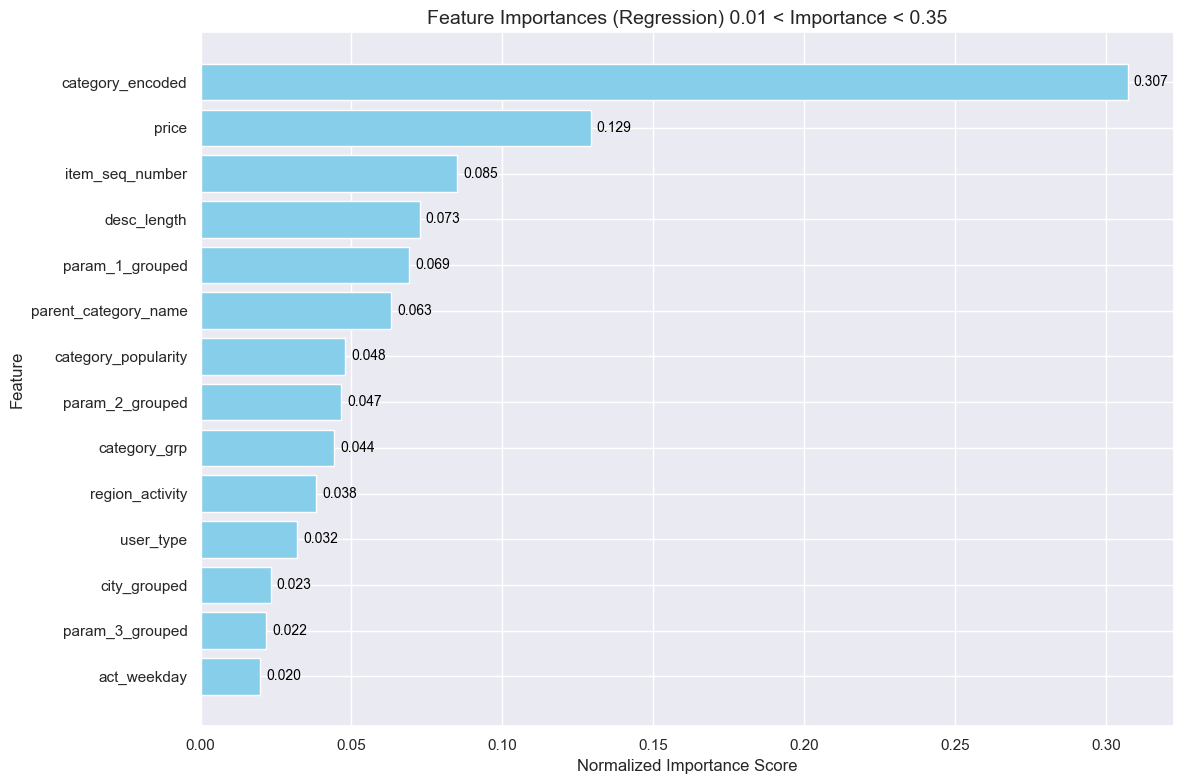

In [67]:
importances = best_cb_model.feature_importances_  
importances = importances / importances.sum()    

importance_df = pd.DataFrame({
    'Feature': X_train_rf_xgb_lgb_cb.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)


filtered_importance = importance_df[
    (importance_df['Importance'] > 0.01) &
    (importance_df['Importance'] < 0.35)
]


plt.figure(figsize=(12, 8))
bars = plt.barh(
    filtered_importance['Feature'],
    filtered_importance['Importance'],
    color='skyblue'
)

plt.title("Feature Importances (Regression) 0.01 < Importance < 0.35", fontsize=14)
plt.xlabel("Normalized Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.gca().invert_yaxis()  


for i, (imp, feat) in enumerate(zip(filtered_importance['Importance'], filtered_importance['Feature'])):
    plt.text(imp + 0.002, i, f"{imp:.3f}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [68]:
importance_df.Feature.tolist()

['category_encoded',
 'price',
 'item_seq_number',
 'desc_length',
 'param_1_grouped',
 'parent_category_name',
 'category_popularity',
 'param_2_grouped',
 'category_grp',
 'region_activity',
 'user_type',
 'city_grouped',
 'param_3_grouped',
 'act_weekday',
 'act_year',
 'act_month']

SHAP Values Summary (Selected Features)


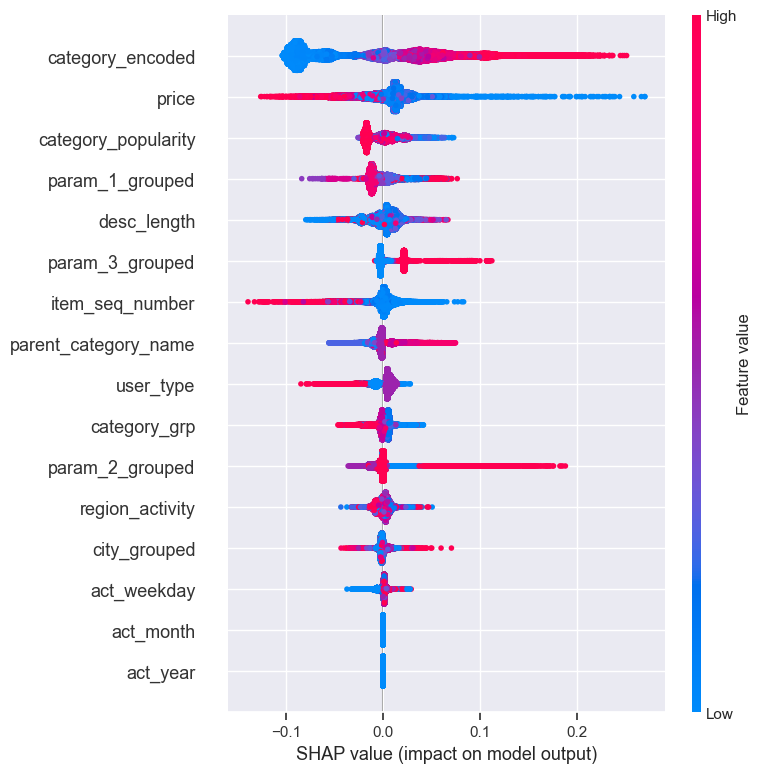

In [69]:
selected_features = [
'price',
 'desc_length',
 'item_seq_number',
 'category_encoded',
 'region_activity',
 'category_grp',
 'category_popularity',
 'param_1_grouped',
 'city_grouped',
 'act_weekday',
 'parent_category_name',
 'param_2_grouped',
 'user_type',
 'param_3_grouped',
 'act_year',
 'act_month'
]

explainer = shap.TreeExplainer(best_lgb_model)
shap_values = explainer.shap_values(X_train_rf_xgb_lgb_cb)


shap_df = pd.DataFrame(shap_values, columns=X_train_rf_xgb_lgb_cb.columns)


shap_selected = shap_df[selected_features]
X_selected = X_train_rf_xgb_lgb_cb[selected_features]

print("SHAP Values Summary (Selected Features)")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_selected.values, X_selected, show=False)
plt.tight_layout()
plt.show()


In [74]:
selected_columns = [
    'price',
 'desc_length',
 'item_seq_number',
 'category_encoded',
 'region_activity',
 'category_grp',
 'category_popularity',
 'param_1_grouped',
 'city_grouped',
 'act_weekday',
 'parent_category_name',
 'param_2_grouped',
 'user_type',
 'param_3_grouped'
   
]

new_inputs_cb = data_rf_xgb_lgb_cb[selected_columns]


In [76]:
X_train_cb, X_test_cb, y_train, y_test = train_test_split(new_inputs_cb, output, test_size=0.2, random_state=42)

In [77]:
def best_params_for_model(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE'])
    }

    cb_reg = CatBoostRegressor(**param, random_state=42, verbose=0)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    r2 = cross_val_score(cb_reg, X_train_cb, y_train, cv=kf, scoring='r2', n_jobs=-1).mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=20)  

best_params = study.best_params
print('Best trial value (R²): {:.3f}'.format(study.best_value))
print('Best params:', best_params)

best_cb_model_imp = CatBoostRegressor(**best_params, random_state=42)


[I 2025-11-10 17:09:13,073] A new study created in memory with name: no-name-ef08437d-9618-4624-9ba5-d5fd2045fb66
C:\Users\user\AppData\Local\Temp\ipykernel_13456\3504455294.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_13456\3504455294.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-11-10 17:09:30,419] Trial 0 finished with value: 0.17229725594063616 and parameters: {'iterations': 629, 'learning_rate': 0.028882392706919013, 'depth': 9, 'l2_leaf_reg': 0.5520036290584807, 'loss

Best trial value (R²): 0.175
Best params: {'iterations': 313, 'learning_rate': 0.044599022099742085, 'depth': 8, 'l2_leaf_reg': 0.8698058925791055, 'loss_function': 'RMSE'}


In [79]:
train_and_evaluate_model('CB opitimized for selected features', best_cb_model_imp, X_train_cb, y_train, X_test_cb, y_test)

0:	learn: 0.2584592	total: 39ms	remaining: 12.2s
1:	learn: 0.2569839	total: 67.5ms	remaining: 10.5s
2:	learn: 0.2556246	total: 94.6ms	remaining: 9.78s
3:	learn: 0.2543744	total: 120ms	remaining: 9.24s
4:	learn: 0.2531535	total: 145ms	remaining: 8.91s
5:	learn: 0.2520821	total: 165ms	remaining: 8.45s
6:	learn: 0.2510687	total: 183ms	remaining: 8.01s
7:	learn: 0.2501366	total: 198ms	remaining: 7.55s
8:	learn: 0.2492657	total: 213ms	remaining: 7.2s
9:	learn: 0.2484477	total: 222ms	remaining: 6.74s
10:	learn: 0.2477198	total: 230ms	remaining: 6.31s
11:	learn: 0.2470458	total: 237ms	remaining: 5.96s
12:	learn: 0.2464135	total: 248ms	remaining: 5.72s
13:	learn: 0.2457466	total: 257ms	remaining: 5.48s
14:	learn: 0.2451742	total: 266ms	remaining: 5.29s
15:	learn: 0.2446547	total: 278ms	remaining: 5.15s
16:	learn: 0.2441393	total: 288ms	remaining: 5.01s
17:	learn: 0.2436633	total: 299ms	remaining: 4.89s
18:	learn: 0.2432179	total: 307ms	remaining: 4.76s
19:	learn: 0.2428093	total: 316ms	remaini

[0.2354997442548048, 0.17489671447602195]

In [ ]:
#VOTING

In [80]:
inputs_vot = data_knn.drop('deal_probability', axis=1)
output = data_knn['deal_probability']

X_train, X_test, y_train, y_test = train_test_split(inputs_vot, output, test_size=0.2, random_state=42)
X_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])]
X_test.columns  = [f'feature_{i}' for i in range(X_test.shape[1])]


In [81]:
def best_params_lgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    model = LGBMRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1, error_score='raise').mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(best_params_lgb, n_trials=20)

best_params_lgb_model = study.best_params
best_lgb_model_vot = LGBMRegressor(**best_params_lgb_model, random_state=42)


[I 2025-11-10 17:14:06,895] A new study created in memory with name: no-name-0d7d2635-6db9-4dc6-81a6-313ddc0d7783
[I 2025-11-10 17:14:19,282] Trial 0 finished with value: 0.20973823692309063 and parameters: {'n_estimators': 704, 'learning_rate': 0.03562878782720205, 'max_depth': 6, 'num_leaves': 33, 'subsample': 0.8095693632373189, 'colsample_bytree': 0.7888991023695207, 'reg_alpha': 0.045886798706530785, 'reg_lambda': 0.1846144986948175}. Best is trial 0 with value: 0.20973823692309063.
[I 2025-11-10 17:14:29,655] Trial 1 finished with value: 0.2103543860317599 and parameters: {'n_estimators': 997, 'learning_rate': 0.0380965583293588, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7269391845100829, 'colsample_bytree': 0.8839885566742554, 'reg_alpha': 0.9159297025123737, 'reg_lambda': 0.5333327251880121}. Best is trial 1 with value: 0.2103543860317599.
[I 2025-11-10 17:14:35,239] Trial 2 finished with value: 0.19582664032543173 and parameters: {'n_estimators': 544, 'learning_rate': 0

In [82]:
def best_params_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

    model = RandomForestRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1).mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(best_params_rf, n_trials=20)

best_params_rf_model = study.best_params
best_rf_model = RandomForestRegressor(**best_params_rf_model, random_state=42)


[I 2025-11-10 17:16:42,256] A new study created in memory with name: no-name-27176af5-429c-4ce7-98a3-589d519612f5
[I 2025-11-10 17:16:59,434] Trial 0 finished with value: 0.20480080276097357 and parameters: {'n_estimators': 183, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.20480080276097357.
[I 2025-11-10 17:17:25,164] Trial 1 finished with value: 0.20598523319301779 and parameters: {'n_estimators': 287, 'max_features': 'sqrt', 'max_depth': 35, 'min_samples_split': 19, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.20598523319301779.
[I 2025-11-10 17:17:44,922] Trial 2 finished with value: 0.20785554566464573 and parameters: {'n_estimators': 272, 'max_features': 'log2', 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.20785554566464573.
[I 2025-11-10 17:18:17,128] Trial 3 finished with value: 0.20752723055310698 and parameters: {'n_estimators': 368, 'max_fe

In [83]:
def xgb_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10)
    }
    model = XGBRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=20)
best_xgb_model = XGBRegressor(**study.best_params)

[I 2025-11-10 17:23:41,645] A new study created in memory with name: no-name-d859df67-aed3-4691-a527-2b1807428b05
C:\Users\user\AppData\Local\Temp\ipykernel_13456\2940635846.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
[I 2025-11-10 17:23:44,310] Trial 0 finished with value: -0.1310394549315671 and parameters: {'n_estimators': 380, 'learning_rate': 0.30155351307993733, 'max_depth': 3, 'subsample': 0.8333094152338241, 'colsample_bytree': 0.5433681914888616, 'gamma': 7.210826342095164}. Best is trial 0 with value: -0.1310394549315671.
C:\Users\user\AppData\Local\Temp\ipykernel_13456\2940635846.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

In [84]:
def catboost_objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'loss_function': 'RMSE'
    }
    model = CatBoostRegressor(**param, verbose=0)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(catboost_objective, n_trials=20)
best_cb_model = CatBoostRegressor(**study.best_params, verbose=0)

[I 2025-11-10 17:24:22,172] A new study created in memory with name: no-name-7971ad6f-0141-442c-8ff2-eef0ae905611
C:\Users\user\AppData\Local\Temp\ipykernel_13456\3454682232.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_13456\3454682232.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-11-10 17:25:23,809] Trial 0 finished with value: -0.12810193172696618 and parameters: {'iterations': 858, 'learning_rate': 0.054636915050557476, 'depth': 10, 'l2_leaf_reg': 0.1669859619763364}. Be

In [85]:
def train_and_evaluate_model_regression(model_name, model, X_train, y_train, X_test, y_test):
    try:
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # manual RMSE hesabı (compatibility üçün)
        metrics = {
            "RMSE": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error,
            "R2": r2_score
        }

        results = []
        for dataset_name, y_true, y_pred in [("Train", y_train, y_train_pred), ("Test", y_test, y_test_pred)]:
            row = {"Dataset": dataset_name, "Model": model_name}
            for metric_name, metric_func in metrics.items():
                row[metric_name] = metric_func(y_true, y_pred)
            results.append(row)

        final_df = pd.DataFrame(results)
        return final_df

    except Exception as e:
        print(f"An error occurred while evaluating the model {model_name}: {e}")
        return None


In [86]:
voting_reg = VotingRegressor(
    estimators=[
        ('lgb', best_lgb_model),
        ('xgb', best_xgb_model),
        ('cat', best_cb_model)
    ]
)

df_voting = train_and_evaluate_model_regression('Voting Regressor', voting_reg, X_train, y_train, X_test, y_test)
print(df_voting)



Training Voting Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 60136, number of used features: 87
[LightGBM] [Info] Start training from score 0.088868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [87]:
stack_reg = StackingRegressor(
    estimators=[
        ('lgb', best_lgb_model),
        ('xgb', best_xgb_model),
        ('cat', best_cb_model)
    ],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42), 
    passthrough=True,
    cv=5
)

df_stack = train_and_evaluate_model_regression('Stacking Regressor (Final RF)', stack_reg, X_train, y_train, X_test, y_test)
print(df_stack)



Training Stacking Regressor (Final RF)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 60136, number of used features: 87
[LightGBM] [Info] Start training from score 0.088868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu